In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [3]:
print('X_train shape:', X_train_orig.shape)
print('Y_train shape:', Y_train_orig.shape)
print('X_test shape:', X_test_orig.shape)
print('Y_test shape:', Y_test_orig.shape)
'''
训练集：1080样本，每个64x64x3
测试集：120样本
'''

X_train shape: (1080, 64, 64, 3)
Y_train shape: (1, 1080)
X_test shape: (120, 64, 64, 3)
Y_test shape: (1, 120)


'\n训练集：1080样本，每个64x64x3\n测试集：120样本\n'

Label: 5


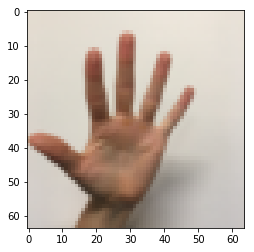

In [4]:
%matplotlib inline
sa_index = 3
sample = X_train_orig[sa_index]
sample_class = Y_train_orig[:, sa_index]
plt.imshow(sample)
print('Label:', str(np.squeeze(sample_class)))

In [5]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [6]:
def create_placeholder(X_shape, Y_shape):
    '''
    '''
    (m, n_H0, n_W0, n_C0) = X_shape
    (_, n_y) = Y_shape
    with tf.name_scope('input'):
        X = tf.placeholder(shape=[None, n_H0, n_W0, n_C0], dtype=tf.float32, name='X')
    Y = tf.placeholder(shape=[None, n_y], dtype=tf.float32, name='Y_hat')
    
    return X, Y

In [15]:
def initialize_parameters(init_parm):
    '''
    init_parm:每一层的参数字典
                {layer_index:{filter_shape, conv_stride, conv_pad, 
                            act_func, 
                            pool, pool_param:[pool_ksize, pool_stride, pool_pad]}
                    ...
                }
    '''
    initialize = tf.contrib.layers.xavier_initializer(seed=0)
    L = len(init_parm.keys())
    filters = {}
    for l in range(1, L+1):
        filters['W' + str(l)] = tf.get_variable(shape=init_parm[l]['filter_shape'], dtype=tf.float32, initializer=initialize, name='W1' + str(l))
    return filters

In [16]:
def add_layer(index, inpt, filt, s, pad, pool, pool_param, activate_func='ReLu'):
    with tf.name_scope('layer' + str(index)):
        #conv layer
        Z = tf.nn.conv2d(input=inpt, filter=filt, strides=[1, s, s, 1], padding=pad)
        #ReLu layer
        if activate_func == 'ReLu':
            A = tf.nn.relu(Z)
        else:
            A = Z
        #max_pool layer
        if pool == 'max':
            pool_k, pool_s, pool_pad = pool_param
            P = tf.nn.max_pool(A, ksize=[1, pool_k, pool_k, 1], strides=[1, pool_s, pool_s, 1], padding=pool_pad)
        else:
            P = A
    return P

In [17]:
def forward_propagation(X, init_param, filters):
    '''
    init_parm:
    filters:
    '''
    L = len(init_param.keys())
    A = X
    for l in range(1, L+1):
        params = init_param[l]
        A = add_layer(l, A, filters['W' + str(l)], s=params['conv_stride'], pad=params['conv_pad'], pool=params['pool'], pool_param=params['pool_param'])
    with tf.name_scope('Final_Layer'):
        F = tf.contrib.layers.flatten(A)
        Z = tf.contrib.layers.fully_connected(F, CLASSES, activation_fn=None,)
    return Z

In [18]:
def compute_cost(Z, Y):
    with tf.name_scope('cost_calculate'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z, labels=Y), name='cost')
    return cost

In [1]:
def random_mini_batches(X, Y, minibatch_size=64, seed=0):
    m = X.shape[0]
    mini_batches = []
    np.random.seed(seed)
    num_batches = int(m/minibatch_size)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation]
    
    batch = 0
    for batch in range(num_batches):
        batch_X = shuffled_X[batch*minibatch_size:(batch + 1)*minibatch_size]
        batch_Y = shuffled_Y[batch*minibatch_size:(batch + 1)*minibatch_size]
        mini_batches.append([batch_X, batch_Y])
    if m%minibatch_size != 0:
        batch_X = shuffled_X[(batch + 1)*minibatch_size : m]
        batch_Y = shuffled_Y[(batch + 1)*minibatch_size : m]
        mini_batches.append([batch_X, batch_Y])
    return mini_batches

In [19]:
def model(X_train, Y_train, X_test, Y_test, init_param, learning_rate=0.011, epochs=100, minibatch_size=64, print_cost=False):
    '''
    init_parm:每一层的参数字典
                {layer_index:{filter_shape, conv_stride, conv_pad,
                            act_func,
                            pool, pool_param:[pool_ksize, pool_stride, pool_pad]}
                    ...
                }
    '''
    (m, n_H0, n_W0, n_C0) = X_train.shape
    (_, n_y) = Y_train.shape

    X, Y = create_placeholder(X_train.shape, Y_train.shape)
    filters = initialize_parameters(init_param)
    Z = forward_propagation(X, init_param, filters)
    cost = compute_cost(Z, Y)
    with tf.name_scope('Train'):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    with tf.name_scope('Pred'):
        pred = tf.argmax(Z, 1)
        pred_true = tf.equal(pred, tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(pred_true, tf.float32), name='Accuracy')

    initer = tf.global_variables_initializer()
    saver = tf.train.Saver()
    cost_recorder = []

    with tf.Session() as sess:
        merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter('logs/', sess.graph)
        sess.run(initer)

        num_batches = int(m/minibatch_size)
        for epoch in range(epochs):
            epoch_cost = 0.
            mini_batches = random_mini_batches(X_train, Y_train, minibatch_size, seed=epoch)
            for [batch_X, batch_Y] in mini_batches:
                food = {
                    X: batch_X,
                    Y: batch_Y
                }
                sess.run(optimizer, feed_dict=food)
                epoch_cost += sess.run(cost, feed_dict=food)
            epoch_cost /= num_batches
            cost_recorder.append(epoch_cost)
            if (epoch + 1) % 5 == 1:
                print('Cost after Iter: %i\t: %f'%(epoch, epoch_cost))
                reus = sess.run(merged, feed_dict={X:X_train, Y:Y_train})
                writer.add_summary(reus, epoch)
        # saver.save(sess, 'my_net/save_1.ckpt')
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Test Accuracy:", test_accuracy)

In [20]:
#配置

np.random.seed(1)
tf.set_random_seed(1)
SEED = 1
CLASSES = 6
learning_rate = 0.011
init_parm = {
    1:{
        'filter_shape':[4, 4, 3, 8],
        'conv_stride':1,
        'conv_pad':'SAME',
        'act_func':'ReLu',
        'pool':'max',
        'pool_param':[8, 8, 'SAME']
    },
    2:{
        'filter_shape':[2, 2, 8, 16],
        'conv_stride':1,
        'conv_pad':'SAME',
        'act_func':'ReLu',
        'pool':'max',
        'pool_param':[4, 4, 'SAME']
    }
}

In [21]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, CLASSES)
Y_test = convert_to_one_hot(Y_test_orig, CLASSES)
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)


In [22]:
model(X_train, Y_train, init_parm, learning_rate)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [ ]:
layers_params: (dictionary) {
                            layer_index(int):{
                                'layer_type':"relu",
                                'inner_layer_params':[size, stride, padding],
                                'act_func':""
                                'pooling':[pooling_type, [ksize, stride, padding]]
                                    };
                            ayrt_index(int):{
                                'layer_type':"fc",
                                'flatten':(bool),
                                'num_output':(int)
                                    }
                        }